In [1]:
from transformers import pipeline
import torch
import string


from transformers import BertTokenizer, BertForMaskedLM
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased').eval()

from transformers import BartTokenizer, BartForConditionalGeneration
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large').eval()

from transformers import ElectraTokenizer, ElectraForMaskedLM
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-generator')
electra_model = ElectraForMaskedLM.from_pretrained('google/electra-small-generator').eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

C:\Users\sheng\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sheng\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at google/electra-small-generator and are newly initialized: ['electra.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
top_k = 5

def decode(tokenizer, pred_idx, top_clean):
    ignore_tokens = string.punctuation + '[PAD]'
    tokens = []
    for w in pred_idx:
        token = ''.join(tokenizer.decode(w).split())
        if token not in ignore_tokens:
            tokens.append(token.replace('##', ''))
    return '\n'.join(tokens[:top_clean])


def encode(tokenizer, text_sentence, add_special_tokens=True):
    text_sentence = text_sentence.replace('<mask>', tokenizer.mask_token)
    # if <mask> is the last token, append a "." so that models dont predict punctuation.
    if tokenizer.mask_token == text_sentence.split()[-1]:
        text_sentence += ' .'

    input_ids = torch.tensor([tokenizer.encode(text_sentence, add_special_tokens=add_special_tokens)])
    mask_idx = torch.where(input_ids == tokenizer.mask_token_id)[1].tolist()[0]
    return input_ids, mask_idx


def get_predictions(text_sentence, top_clean=5):
    # ========================= BERT =================================
    print(text_sentence)
    input_ids, mask_idx = encode(bert_tokenizer, text_sentence)
    with torch.no_grad():
        predict = bert_model(input_ids)[0]
    bert = decode(bert_tokenizer, predict[0, mask_idx, :].topk(top_k).indices.tolist(), top_clean)
    
    input_ids, mask_idx = encode(bart_tokenizer, text_sentence, add_special_tokens=True)
    with torch.no_grad():
        predict = bart_model(input_ids)[0]
    bart = decode(bart_tokenizer, predict[0, mask_idx, :].topk(top_k).indices.tolist(), top_clean)
    
    input_ids, mask_idx = encode(electra_tokenizer, text_sentence, add_special_tokens=True)
    with torch.no_grad():
        predict = electra_model(input_ids)[0]
    electra = decode(electra_tokenizer, predict[0, mask_idx, :].topk(top_k).indices.tolist(), top_clean)

    return {'bert': bert,"bart":bart,"electra":electra}

In [3]:
input_text="Hello, how are"
input_text += ' <mask>'
res = get_predictions(input_text, top_clean=int(top_k))

Hello, how are <mask>


In [4]:
res["bert"].split("\n")

['you', 'ya', 'we', 'things', 'ye']

In [5]:
res["bart"].split("\n")

['you', 'things', 'ya', 'we', 'y']

In [6]:
res["electra"].split("\n")

['you', 'we', 'they', 'i', 'these']

In [36]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(text)
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  39
Word: ID
------------
<oov>:  1


KeyError: 'strong'

In [32]:
input_sequences = []
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

ValueError: max() arg is an empty sequence

In [15]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['from', 'fairest', 'creatures', 'we', 'desire']
increase


In [16]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X, Y, epochs=50, verbose=1)

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

C:\Users\sheng\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
1388/1388 [==============================] - 247s 177ms/step - loss: 6.3676 - accuracy: 0.0827 - val_loss: 6.7137 - val_accuracy: 0.1066
Epoch 2/10
1388/1388 [==============================] - 233s 168ms/step - loss: 6.4258 - accuracy: 0.1175 - val_loss: 7.0606 - val_accuracy: 0.1082
Epoch 3/10
1388/1388 [==============================] - 238s 171ms/step - loss: 6.2068 - accuracy: 0.1366 - val_loss: 7.2836 - val_accuracy: 0.1075
Epoch 4/10
1388/1388 [==============================] - 238s 171ms/step - loss: 5.7105 - accuracy: 0.1656 - val_loss: 7.5751 - val_accuracy: 0.0954
Epoch 5/10
1388/1388 [==============================] - 232s 167ms/step - loss: 5.1736 - accuracy: 0.2033 - val_loss: 7.7755 - val_accuracy: 0.0860
Epoch 6/10
1388/1388 [==============================] - 230s 166ms/step - loss: 4.6548 - accuracy: 0.2476 - val_loss: 8.2830 - val_accuracy: 0.0790
Epoch 7/10
1388/1388 [==============================] - 229s 165ms/step - loss: 4.2101 - accuracy: 0.2921 - val_

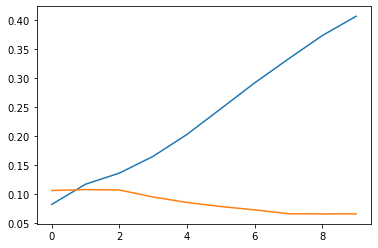

In [28]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()